# Jupyter Notebook - Electronics Demos
This notebook demonstrates several packages that can be used to support the creation of assets relating to *electronics*.

In [1]:
%matplotlib inline

## Drawing Electrical Circuit Diagrams

The `schemdraw` package can be used to write descriptions of electrical circuit diagrams.

Examples: https://cdelker.bitbucket.io/SchemDraw/SchemDraw.html


We can parameterise values to allow us to refer to diagrams in text using similar values.

In [2]:
import SchemDraw as schem
import SchemDraw.elements as e

In [6]:
#Would be nice if we could find a way of handling units better?
#Maybe a package that gets this from value and chooses unit modifier appropriately?

R=100 * 10**3
V=10
C=0.1 * 10**-6

V_str='{V}V'.format(V=V)
R_str='{R}K$\Omega$'.format(R=R/10**3)
C_str='{C}$\mu$F'.format(C=C/10**-6)

d = schem.Drawing()
V1 = d.add(e.SOURCE_V, label=V_str)
d.add(e.RES, d='right', label=R_str)
d.add(e.CAP, d='down', botlabel=C_str)
d.add(e.LINE, to=V1.start);

The following circuit shows a {{V_str}} source connected in series to a {{R_str}} resistor and a {{C_str}} capacitor.

{{d.draw()}}

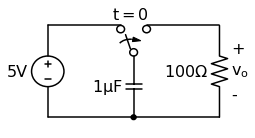

In [19]:
d = schem.Drawing()
V1 = d.add(e.SOURCE_V, label='5V')
d.add(e.LINE, d='right', l=d.unit*.75)
S1 = d.add(e.SWITCH_SPDT2_CLOSE, d='up', anchor='b', rgtlabel='$t=0$')
d.add(e.LINE, d='right', xy=S1.c,  l=d.unit*.75)
d.add(e.RES, d='down', label='$100\Omega$', botlabel=['+','$v_o$','-'])
d.add(e.LINE, to=V1.start)
d.add(e.CAP, xy=S1.a, d='down', toy=V1.start, label='1$\mu$F')
d.add(e.DOT)
d.draw(showplot=False)